In [1]:
%matplotlib inline
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

def plotPlayer(id):
    player = id
    fig = plt.figure(figsize=(10, 6))
    ax = fig.gca()
    df[df['id'] == player][['wrating', 'age']].set_index('age').sort_index().plot(ax=ax)
    df[df['id'] == player][['rating', 'age']].set_index('age').sort_index().plot(ax=ax)
    return (df[df['id'] == player][['wrating', 'tour', 'age', 'team', 'start']].set_index('age').sort_index())

In [2]:
def load_csv(system):
    df = pd.read_csv(system + '.csv', encoding="utf-8")
    df.start = pd.to_datetime(df.start, format='%d/%m/%Y')
    df.end = pd.to_datetime(df.end, format='%d/%m/%Y')
    dob = pd.read_csv('dob.csv', encoding="utf-8")
    dob.id = dob.id.str.replace(r'\W+', '').str.lower()
    return df, dob

def cumulativeRating(diff, ratingName, df):
    cumsums = df[['id', 'start', diff]].groupby(['id', 'start']).sum().groupby(level=0).cumsum()
    df = df.set_index(['id', 'start'])
    df['cumur'] = cumsums
    df = df.reset_index()
    init = df[df['startglicko2rating'].notnull()].sort_values('start')[['startglicko2rating', 'id']].groupby('id').first().reset_index().rename(columns={'startglicko2rating': 'init'})
    df = pd.merge(df, init, how='left', on='id')
    df[ratingName] = df.cumur + df.init
    return df

def teamRating(rating, df):
    teameff = df.merge((df.groupby(['team', 'start']).mean()[rating] * 5).reset_index().rename(columns={rating: 'teamrating'}), on=['team', 'start'])
    teameff.teamrating = (teameff.teamrating - teameff[rating]) / 4
    return teameff

def experience(df):
    dfid2 = pd.DataFrame()
    for player in df.id.unique():
        dfid = pd.DataFrame(df[df['id'] == player].sort_values('start').tour.unique()).reset_index().rename(columns={'index': 'exp', 0: 'tour'})
        dfid['id'] = player
        dfid2 = pd.concat([dfid2, dfid])
    return pd.merge(df, dfid2, how='left', on=['id', 'tour'])
    
def dobMerge(df, dob):
    dob.id = dob.id.str.replace(r'\W+', '').str.lower()
    df = df.merge(dob, how='left', on=['id'])
    df.dob = pd.to_datetime(df.dob, format='%Y/%m/%d')
    df['age'] = (df.start - df.dob) / pd.Timedelta(days=365.25)
    return df

In [3]:
df, dob = load_csv('glicko2')
df['diffr'] = df.endglicko2rating - df.startglicko2rating
df = cumulativeRating('diffr', 'normalRating', df)
df = teamRating('normalRating', df)
df = experience(df)
df.drop_duplicates(subset=['id', 'start'], inplace=True)
df.dropna(inplace=True)
df = dobMerge(df, dob)
df.dropna(inplace=True)
df = df[(df.prizeusd != 'Nan')]
df.prizeusd = pd.to_numeric(df.prizeusd)

In [4]:
df['season'] = 'ti3'
df.loc[(df.start > pd.to_datetime('2013-08-02')) & (df.start <= pd.to_datetime('2014-07-08')), 'season'] = 'ti4'
df.loc[(df.start > pd.to_datetime('2014-07-08')) & (df.start <= pd.to_datetime('2015-07-27')), 'season'] = 'ti5'
df.loc[(df.start > pd.to_datetime('2015-07-27')) & (df.start <= pd.to_datetime('2016-08-02')), 'season'] = 'ti6'
df.loc[(df.start > pd.to_datetime('2016-08-02')) & (df.start <= pd.to_datetime('2017-08-02')), 'season'] = 'ti7'

In [5]:
df['tiprize'] = np.log(int(df[df['tour'] == 'The International 2013'].prizeusd.iloc[0]))
df.loc[(df.season == 'ti4'), 'tiprize'] = np.log(int(df[df['tour'] == 'The International 2014'].prizeusd.iloc[0]))
df.loc[(df.season == 'ti5'), 'tiprize'] = np.log(int(df[df['tour'] == 'The International 2015'].prizeusd.iloc[0]))
df.loc[(df.season == 'ti6'), 'tiprize'] = np.log(int(df[df['tour'] == 'The International 2016'].prizeusd.iloc[0]))
df.loc[(df.season == 'ti7'), 'tiprize'] = np.log(int(df[df['tour'] == 'The International 2017'].prizeusd.iloc[0]))

df['wdiffr'] = (df.prizeusd.apply(np.log) / df.tiprize) * df.diffr

#cumulative sum of wdiffr
cumsums = df[['id', 'start', 'wdiffr']].groupby(['id', 'start']).sum().groupby(level=0).cumsum()
df = df.set_index(['id', 'start'])
df['cumuwr'] = cumsums
df = df.reset_index()
df['wrating'] = df.cumuwr + df.init

In [6]:
ent = pd.DataFrame(df.id.unique()).reset_index().rename(columns={'index': 'entity', 0: 'id'})
df = ent.merge(df, on='id', how='left')

In [7]:
def panelOLSResult(df, Y, X):
    from linearmodels import PanelOLS 
    panel_data = df.set_index(['entity', 'start']).sort_index()
    panel_data['agesq'] = panel_data.age ** 2
    panel_data['const'] = 1
    panel_data['lexp'] = (panel_data['exp'] + 1).apply(np.log)
    Y = panel_data[Y]
    X = panel_data[X]
    mod = PanelOLS(Y, X, entity_effects=True)
    return mod.fit()

def feResult(res):
    fe = res.estimated_effects.reset_index().drop_duplicates().drop_duplicates(subset=['entity']).drop('time', 1)
    return ent.merge(fe, on='entity').sort_values('estimated_effects', ascending=False)

### Age and experience

In [8]:
df[['wrating', 'age', 'exp']].describe()

,wrating,age,exp
count,5251.000000,5251.000000,5251.000000
mean,1759.784722,22.611274,24.626357
std,175.103877,2.527670,17.632583
min,1281.650952,15.739904,0.000000
25%,1637.702582,20.882957,11.000000
50%,1739.296889,22.666667,21.000000
75%,1865.689863,24.394251,36.000000
max,2275.313145,30.149213,83.000000


In [9]:
res = panelOLSResult(df, 'wrating', ['age', 'agesq', 'lexp'])

In [10]:
res.summary

Dep. Variable:,wrating,R-squared:,0.2819
Estimator:,PanelOLS,R-squared (Between):,0.9929
No. Observations:,5251,R-squared (Within):,0.2819
Date:,"Sat, Mar 03 2018",R-squared (Overall):,0.9916
Time:,15:20:03,Log-likelihood,-3.04e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,650.30
Entities:,278,P-value,0.0000
Avg Obs:,18.888,Distribution:,"F(3,4970)"
Min Obs:,1.0000,,
Max Obs:,76.000,F-statistic (robust):,650.30


## $wrating = -2.6996*age^2+130.57*age+65.331*log(lexp)$
### $peakage: 24.18$

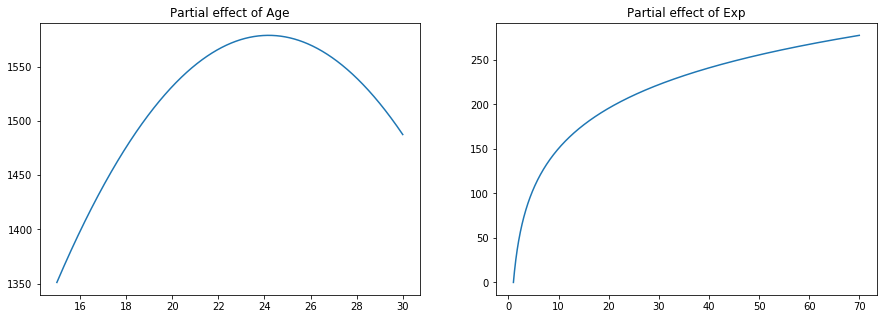

In [11]:
# create 1000 equally spaced points between -10 and 10
agex = np.linspace(15, 30, 1000)
expx = np.linspace(1, 70, 1000)
# calculate the y value for each element of the x vector
age = res.params.agesq*agex**2 + res.params.age*agex 
exp = res.params.lexp*np.log(expx)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(agex, age)
ax[0].set_title("Partial effect of Age")
ax[1].plot(expx, exp)
ax[1].set_title("Partial effect of Exp")
plt.show()

### Teammate effect
teamrating = (average rating of all player in that team at that tournament * 5) - (that player rating)

In [12]:
df[['wrating', 'age', 'exp', 'teamrating']].describe()

,wrating,age,exp,teamrating
count,5251.000000,5251.000000,5251.000000,5251.000000
mean,1759.784722,22.611274,24.626357,1840.911627
std,175.103877,2.527670,17.632583,192.464997
min,1281.650952,15.739904,0.000000,1321.284974
25%,1637.702582,20.882957,11.000000,1705.510679
50%,1739.296889,22.666667,21.000000,1831.697828
75%,1865.689863,24.394251,36.000000,1975.672821
max,2275.313145,30.149213,83.000000,2413.802158


In [13]:
res = panelOLSResult(df, 'wrating', ['age', 'agesq', 'lexp', 'teamrating'])

In [14]:
res.summary

Dep. Variable:,wrating,R-squared:,0.4509
Estimator:,PanelOLS,R-squared (Between):,0.6550
No. Observations:,5251,R-squared (Within):,0.4509
Date:,"Sat, Mar 03 2018",R-squared (Overall):,0.7109
Time:,15:20:09,Log-likelihood,-2.97e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,1019.9
Entities:,278,P-value,0.0000
Avg Obs:,18.888,Distribution:,"F(4,4969)"
Min Obs:,1.0000,,
Max Obs:,76.000,F-statistic (robust):,1019.9


## $wrating = -2.816*age^2+157.62*age+18.362*log(lexp)+0.2909*teammaterating$
### $peak age: 27.98$

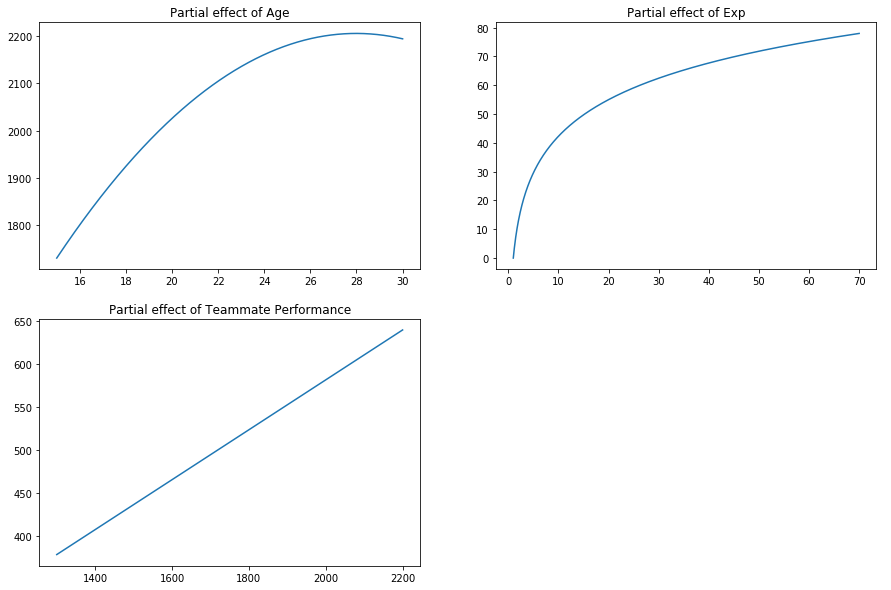

In [15]:
# create 1000 equally spaced points between -10 and 10
agex = np.linspace(15, 30, 1000)
expx = np.linspace(1, 70, 1000)
teamx = np.linspace(1300, 2200, 1000)
# calculate the y value for each element of the x vector
age = res.params.agesq*agex**2 + res.params.age*agex 
exp = res.params.lexp*np.log(expx)
team = res.params.teamrating*teamx 

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0, 0].plot(agex, age)
ax[0, 0].set_title("Partial effect of Age")
ax[0, 1].plot(expx, exp)
ax[0, 1].set_title("Partial effect of Exp")
ax[1, 0].plot(teamx, team)
ax[1, 0].set_title("Partial effect of Teammate Performance")
ax[1, 1].axis('off')

plt.show()

### Team Performance = glickorating

In [16]:
import statsmodels.api as sm

C:\Users\nakhonpathompc\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [17]:
df[['wrating', 'age', 'exp', 'startglicko2rating']].describe()

,wrating,age,exp,startglicko2rating
count,5251.000000,5251.000000,5251.000000,5251.000000
mean,1759.784722,22.611274,24.626357,1726.679155
std,175.103877,2.527670,17.632583,106.350814
min,1281.650952,15.739904,0.000000,1326.826060
25%,1637.702582,20.882957,11.000000,1654.136217
50%,1739.296889,22.666667,21.000000,1736.664223
75%,1865.689863,24.394251,36.000000,1806.224329
max,2275.313145,30.149213,83.000000,1952.785682


In [18]:
df

,entity,id,start,team,pos,tour,prizeusd,startglicko2mu,startglicko2phi,startglicko2rating,...,exp,cog,name,dob,age,season,tiprize,wdiffr,cumuwr,wrating
0,0,mushi,2012-09-08,orangeesports,1,WCG Asian Championship 2012,6000.0,1609.568030,65.014671,1447.031352,...,0,Malaysia,Chai Yee Fung,1990-11-27,21.782341,ti3,14.871348,-1.214596,-1.214596,1445.816755
1,0,mushi,2012-10-22,orangeesports,2,G-1 Champions League Season 4,52879.2,1641.538726,67.619164,1472.490816,...,1,Malaysia,Chai Yee Fung,1990-11-27,21.902806,ti3,14.871348,47.650947,46.436351,1493.467703
2,0,mushi,2012-11-29,orangeesports,2,World Cyber Games 2012,33000.0,1697.235587,65.516596,1533.444096,...,2,Malaysia,Chai Yee Fung,1990-11-27,22.006845,ti3,14.871348,-1.442597,44.993754,1492.025105
3,0,mushi,2014-05-24,dk,2,MarsTV Dota 2 League 2014,24046.5,1930.864266,41.671528,1826.685445,...,22,Malaysia,Chai Yee Fung,1990-11-27,23.488022,ti4,16.206471,7.779183,52.772936,1499.804288
4,0,mushi,2015-01-05,lvgaming,5,Dota 2 League Season 5,58397.0,1867.016147,54.064244,1731.855537,...,30,Malaysia,Chai Yee Fung,1990-11-27,24.106776,ti5,16.729469,-1.633441,51.139496,1498.170847
5,0,mushi,2015-01-29,ehome,2,Dota 2 Asia Championships 2015,3057519.0,1800.326513,57.784098,1655.866268,...,31,Malaysia,Chai Yee Fung,1990-11-27,24.172485,ti5,16.729469,-2.081266,49.058230,1496.089581
6,0,mushi,2015-03-09,teammalaysia,5,StarLadder StarSeries Season 12,150000.0,1814.532535,69.229368,1641.459115,...,32,Malaysia,Chai Yee Fung,1990-11-27,24.279261,ti5,16.729469,95.024734,144.082964,1591.114316
7,0,mushi,2015-04-06,teammalaysia,5,i-League Season 3,426720.0,1877.024101,55.925833,1737.209517,...,33,Malaysia,Chai Yee Fung,1990-11-27,24.355921,ti5,16.729469,16.795782,160.878746,1607.910098
8,0,mushi,2015-04-20,fnatic,2,joinDOTA MLG Pro League Season 2,167248.0,1737.963343,65.409879,1574.438646,...,35,Malaysia,Chai Yee Fung,1990-11-27,24.394251,ti5,16.729469,27.273370,188.152116,1635.183467
9,0,mushi,2015-06-20,fnatic,2,ESL One Frankfurt 2015,286622.0,1764.577331,60.862764,1612.420422,...,36,Malaysia,Chai Yee Fung,1990-11-27,24.561259,ti5,16.729469,-1.699859,186.452257,1633.483608


In [19]:
res = panelOLSResult(df, 'wrating', ['age', 'agesq', 'lexp', 'startglicko2rating'])

In [20]:
res.summary

Dep. Variable:,wrating,R-squared:,0.3826
Estimator:,PanelOLS,R-squared (Between):,0.9704
No. Observations:,5251,R-squared (Within):,0.3826
Date:,"Sat, Mar 03 2018",R-squared (Overall):,0.9764
Time:,15:20:14,Log-likelihood,-3.001e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,769.72
Entities:,278,P-value,0.0000
Avg Obs:,18.888,Distribution:,"F(4,4969)"
Min Obs:,1.0000,,
Max Obs:,76.000,F-statistic (robust):,769.72


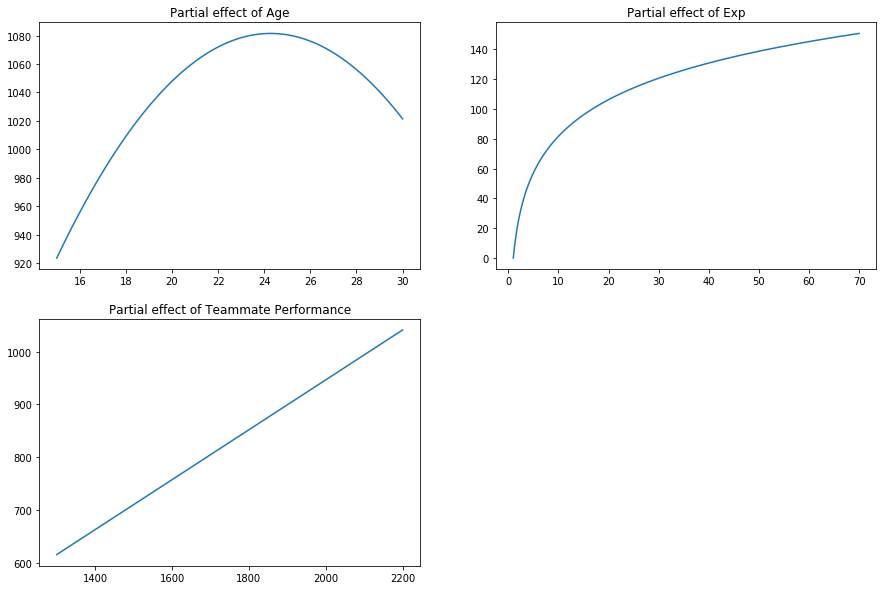

In [21]:
# create 1000 equally spaced points between -10 and 10
agex = np.linspace(15, 30, 1000)
expx = np.linspace(1, 70, 1000)
teamx = np.linspace(1300, 2200, 1000)
# calculate the y value for each element of the x vector
age = res.params.agesq*agex**2 + res.params.age*agex 
exp = res.params.lexp*np.log(expx)
team = res.params.startglicko2rating*teamx 

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0, 0].plot(agex, age)
ax[0, 0].set_title("Partial effect of Age")
ax[0, 1].plot(expx, exp)
ax[0, 1].set_title("Partial effect of Exp")
ax[1, 0].plot(teamx, team)
ax[1, 0].set_title("Partial effect of Teammate Performance")
ax[1, 1].axis('off')

plt.show()

In [22]:
df[['age', 'wrating', 'startglicko2rating', 'teamrating']].corr()

,age,wrating,startglicko2rating,teamrating
age,1.000000,0.032960,0.114025,0.044098
wrating,0.032960,1.000000,0.493680,0.574158
startglicko2rating,0.114025,0.493680,1.000000,0.600692
teamrating,0.044098,0.574158,0.600692,1.000000


In [23]:
from linearmodels import PanelOLS
panel_data = df.set_index(['entity', 'start']).sort_index()
panel_data['agesq'] = panel_data.age ** 2
panel_data['const'] = 1
panel_data['lexp'] = (panel_data['exp'] + 1).apply(np.log)
Y = panel_data['wrating']
X = panel_data[['age', 'agesq', 'const']]
mod = PanelOLS(Y, X, entity_effects=True)
res =  mod.fit()

In [24]:
res.summary

Dep. Variable:,wrating,R-squared:,0.2264
Estimator:,PanelOLS,R-squared (Between):,-1.0174
No. Observations:,5251,R-squared (Within):,0.2264
Date:,"Sat, Mar 03 2018",R-squared (Overall):,-0.4562
Time:,15:20:16,Log-likelihood,-3.06e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,727.45
Entities:,278,P-value,0.0000
Avg Obs:,18.888,Distribution:,"F(2,4971)"
Min Obs:,1.0000,,
Max Obs:,76.000,F-statistic (robust):,727.45


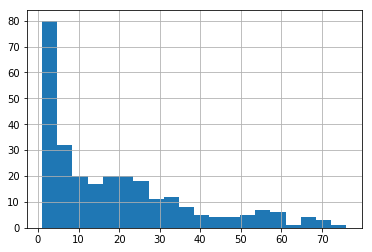

In [25]:
df.groupby('entity').size().hist(bins=20)

In [26]:
df

,entity,id,start,team,pos,tour,prizeusd,startglicko2mu,startglicko2phi,startglicko2rating,...,exp,cog,name,dob,age,season,tiprize,wdiffr,cumuwr,wrating
0,0,mushi,2012-09-08,orangeesports,1,WCG Asian Championship 2012,6000.0,1609.568030,65.014671,1447.031352,...,0,Malaysia,Chai Yee Fung,1990-11-27,21.782341,ti3,14.871348,-1.214596,-1.214596,1445.816755
1,0,mushi,2012-10-22,orangeesports,2,G-1 Champions League Season 4,52879.2,1641.538726,67.619164,1472.490816,...,1,Malaysia,Chai Yee Fung,1990-11-27,21.902806,ti3,14.871348,47.650947,46.436351,1493.467703
2,0,mushi,2012-11-29,orangeesports,2,World Cyber Games 2012,33000.0,1697.235587,65.516596,1533.444096,...,2,Malaysia,Chai Yee Fung,1990-11-27,22.006845,ti3,14.871348,-1.442597,44.993754,1492.025105
3,0,mushi,2014-05-24,dk,2,MarsTV Dota 2 League 2014,24046.5,1930.864266,41.671528,1826.685445,...,22,Malaysia,Chai Yee Fung,1990-11-27,23.488022,ti4,16.206471,7.779183,52.772936,1499.804288
4,0,mushi,2015-01-05,lvgaming,5,Dota 2 League Season 5,58397.0,1867.016147,54.064244,1731.855537,...,30,Malaysia,Chai Yee Fung,1990-11-27,24.106776,ti5,16.729469,-1.633441,51.139496,1498.170847
5,0,mushi,2015-01-29,ehome,2,Dota 2 Asia Championships 2015,3057519.0,1800.326513,57.784098,1655.866268,...,31,Malaysia,Chai Yee Fung,1990-11-27,24.172485,ti5,16.729469,-2.081266,49.058230,1496.089581
6,0,mushi,2015-03-09,teammalaysia,5,StarLadder StarSeries Season 12,150000.0,1814.532535,69.229368,1641.459115,...,32,Malaysia,Chai Yee Fung,1990-11-27,24.279261,ti5,16.729469,95.024734,144.082964,1591.114316
7,0,mushi,2015-04-06,teammalaysia,5,i-League Season 3,426720.0,1877.024101,55.925833,1737.209517,...,33,Malaysia,Chai Yee Fung,1990-11-27,24.355921,ti5,16.729469,16.795782,160.878746,1607.910098
8,0,mushi,2015-04-20,fnatic,2,joinDOTA MLG Pro League Season 2,167248.0,1737.963343,65.409879,1574.438646,...,35,Malaysia,Chai Yee Fung,1990-11-27,24.394251,ti5,16.729469,27.273370,188.152116,1635.183467
9,0,mushi,2015-06-20,fnatic,2,ESL One Frankfurt 2015,286622.0,1764.577331,60.862764,1612.420422,...,36,Malaysia,Chai Yee Fung,1990-11-27,24.561259,ti5,16.729469,-1.699859,186.452257,1633.483608


In [87]:
bal = df.copy()

In [88]:
bal['start'] = bal[bal['tour'] == 'The International 2013'].end.iloc[0]
bal.loc[(bal.season == 'ti4'), 'start'] = bal[bal['tour'] == 'The International 2014'].end.iloc[0]
bal.loc[(bal.season == 'ti5'), 'start'] = bal[bal['tour'] == 'The International 2015'].end.iloc[0]
bal.loc[(bal.season == 'ti6'), 'start'] = bal[bal['tour'] == 'The International 2016'].end.iloc[0]
bal.loc[(bal.season == 'ti7'), 'start'] = bal[bal['tour'] == 'The International 2017'].end.iloc[0]

In [89]:
bal = bal.groupby(['id', 'season'], as_index=False).agg(
                      {'wrating':['mean'], 'dob':'first', 'start':'first', 'exp': 'size', 'startglicko2rating': 'mean', 'teamrating': 'mean', 'pos': 'mean'})

In [90]:
nss = df.drop_duplicates(['id', 'season']).groupby(['id']).size().reset_index()

In [91]:
bal = bal[bal['id'].isin(nss[nss[0] >= 5].id.unique())]

In [92]:
bal.columns = bal.columns.droplevel(level=1)

In [93]:
ent = pd.DataFrame(bal.id.unique()).reset_index().rename(columns={'index': 'entity', 0: 'id'})
bal = ent.merge(bal, on='id', how='left')

In [94]:
dob = bal[['id', 'dob']].drop_duplicates()

In [95]:
unbalanced_data = bal

In [96]:
unbalanced_data = unbalanced_data.rename(columns={'start': 'date'})

In [97]:
all_dates = pd.DataFrame(bal.start.unique()).rename(columns={0: 'date'})

In [98]:
uid = unbalanced_data['id'].unique()
ids_full = np.array([[x]*len(all_dates) for x in range(len(uid))]).flatten()
dates = all_dates['date'].tolist() * len(uid)
balanced_panel = pd.DataFrame({'entity': ids_full, 'date': dates})
rebalanced_data = pd.merge(balanced_panel, unbalanced_data, how='left',
                           on=['entity', 'date'])

In [99]:
balanced_data = rebalanced_data.drop('id', axis=1).merge(ent, how='left', on='entity').drop('dob', axis=1).merge(dob, how='left', on='id')

In [100]:
balanced_data.date = pd.to_datetime(balanced_data.date)

In [101]:
balanced_data['season'] = 'ti7'
balanced_data.loc[(balanced_data.date == pd.to_datetime('2013-08-11')), 'season'] = 'ti3'
balanced_data.loc[(balanced_data.date == pd.to_datetime('2014-07-21')), 'season'] = 'ti4'
balanced_data.loc[(balanced_data.date == pd.to_datetime('2015-08-08')), 'season'] = 'ti5'
balanced_data.loc[(balanced_data.date == pd.to_datetime('2016-08-13')), 'season'] = 'ti6'

In [102]:
balanced_data['age'] = ((balanced_data.date- balanced_data.dob) / pd.Timedelta(days=365.25)).round()
balanced_data['pos'] = balanced_data['pos'].round()

In [103]:
balanced_data = balanced_data[['entity', 'id', 'date', 'pos', 'exp', 'season', 'wrating', 'age', 'startglicko2rating', 'teamrating']]
balanced_data

,entity,id,date,pos,exp,season,wrating,age,startglicko2rating,teamrating
0,0,admiralbulldog,2013-08-11,3.0,11,ti3,1802.276890,23.0,1712.672600,1964.213932
1,0,admiralbulldog,2014-07-21,3.0,19,ti4,1818.341325,24.0,1802.140005,2018.797509
2,0,admiralbulldog,2015-08-08,3.0,10,ti5,1655.009997,25.0,1715.045646,1807.498461
3,0,admiralbulldog,2016-08-13,3.0,14,ti6,1698.970059,26.0,1741.338196,1908.349800
4,0,admiralbulldog,2017-08-12,3.0,1,ti7,1675.999392,27.0,1770.238101,1861.487761
5,1,arteezy,2013-08-11,2.0,2,ti3,1584.140304,17.0,1549.398107,1686.636649
6,1,arteezy,2014-07-21,2.0,9,ti4,1958.758511,18.0,1727.258755,2050.726872
7,1,arteezy,2015-08-08,2.0,16,ti5,2056.436675,19.0,1883.630114,2036.586837
8,1,arteezy,2016-08-13,1.0,15,ti6,2036.786958,20.0,1814.623206,2021.940022
9,1,arteezy,2017-08-12,1.0,12,ti7,2015.028262,21.0,1873.755452,1965.515197


#### Reason of Missing
1. retirement
    * just break and comeback to play after
    * stop playing competitively
2. not enter scene
    * too young
    * playing but not in minor/major tier
3. playing with team without record that season
    * playing in major/minor tier but with new/small team
    * become coach but sometime play

In [104]:
balanced_data = pd.concat([balanced_data, pd.get_dummies(balanced_data.pos)], axis=1)

In [105]:
balanced_data.describe()

,entity,pos,exp,wrating,age,startglicko2rating,teamrating,1.0,2.0,3.0,4.0,5.0
count,150.000000,150.00000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,14.500000,2.76000,10.686667,1819.618412,23.493333,1725.081420,1856.399621,0.240000,0.233333,0.180000,0.220000,0.126667
std,8.684438,1.36927,5.664130,202.812961,2.359464,105.783521,181.680568,0.428514,0.424370,0.385475,0.415634,0.333713
min,0.000000,1.00000,1.000000,1393.339450,17.000000,1396.663234,1321.284974,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,2.00000,7.000000,1684.069300,22.000000,1652.797539,1753.108953,0.000000,0.000000,0.000000,0.000000,0.000000
50%,14.500000,3.00000,11.000000,1781.200016,24.000000,1736.385588,1860.948164,0.000000,0.000000,0.000000,0.000000,0.000000
75%,22.000000,4.00000,15.000000,1969.991475,25.000000,1801.406005,1971.088557,0.000000,0.000000,0.000000,0.000000,0.000000
max,29.000000,5.00000,23.000000,2259.896496,29.000000,1915.703707,2259.458470,1.000000,1.000000,1.000000,1.000000,1.000000


In [106]:
balanced_data['exp'] = balanced_data.groupby('entity').exp.cumsum()

In [110]:
from linearmodels import PanelOLS 
panel_data = balanced_data.set_index(['entity', 'date']).sort_index()
panel_data['lexp'] = (panel_data['exp'] + 1).apply(np.log)
panel_data['agesq'] = panel_data.age ** 2
panel_data['const'] = 1
Y = panel_data['wrating']
X = panel_data[['age', 'agesq', 'lexp', 'teamrating', 'const', 1.0, 2.0, 3.0, 4.0]]
mod = PanelOLS(Y, X, entity_effects=True, time_effects=False)
res = mod.fit()

In [111]:
res.summary

Dep. Variable:,wrating,R-squared:,0.5842
Estimator:,PanelOLS,R-squared (Between):,-0.1020
No. Observations:,150,R-squared (Within):,0.5842
Date:,"Sat, Mar 03 2018",R-squared (Overall):,0.1622
Time:,15:57:12,Log-likelihood,-871.76
Cov. Estimator:,Unadjusted,,
,,F-statistic:,19.671
Entities:,30,P-value,0.0000
Avg Obs:,5.0000,Distribution:,"F(8,112)"
Min Obs:,5.0000,,
Max Obs:,5.0000,F-statistic (robust):,19.671


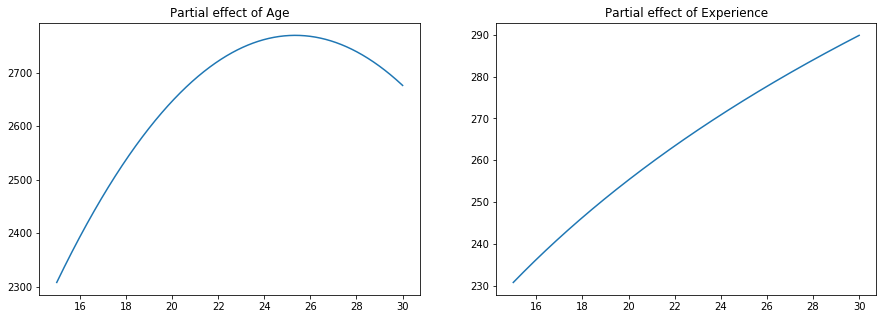

In [115]:
# create 1000 equally spaced points between -10 and 10
agex = np.linspace(15, 30, 1000)
expx = np.linspace(15, 30, 1000)

# calculate the y value for each element of the x vector
age = res.params.agesq*agex**2 + res.params.age*agex
exp = res.params.lexp*np.log(expx)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(agex, age)
ax[0].set_title("Partial effect of Age")
ax[1].plot(expx, exp)
ax[1].set_title("Partial effect of Experience")

plt.show()

In [78]:
res.estimated_effects

estimated_effects
entity time                         
0      2013-08-11         -97.502407
       2014-07-21         -97.502407
       2015-08-08         -97.502407
1      2015-08-08          54.108992
       2016-08-13          54.108992
       2017-08-12          54.108992
2      2013-08-11        -325.746552
       2014-07-21        -325.746552
       2017-08-12        -325.746552
3      2013-08-11         -75.636790
       2014-07-21         -75.636790
       2015-08-08         -75.636790
       2016-08-13         -75.636790
       2017-08-12         -75.636790
4      2015-08-08           0.464745
       2016-08-13           0.464745
       2017-08-12           0.464745
5      2013-08-11         -27.996741
       2014-07-21         -27.996741
       2015-08-08         -27.996741
       2016-08-13         -27.996741
6      2015-08-08          62.184285
       2016-08-13          62.184285
       2017-08-12          62.184285
7      2014-07-21          30.860549
       2015-08-08          30.860549
       2016-08-13          30.860549
       2017-08-12          30.860549
8      2013-08-11         148.911936
       2014-07-21         148.911936
...                              ...
110    2013-08-11         -79.740868
       2014-07-21         -79.740868
       2015-08-08         -79.740868
111    2013-08-11         -59.380075
       2014-07-21         -59.380075
       2015-08-08         -59.380075
       2016-08-13         -59.380075
112    2013-08-11         267.525385
       2014-07-21         267.525385
       2015-08-08         267.525385
       2016-08-13         267.525385
       2017-08-12         267.525385
113    2013-08-11        -137.556229
       2014-07-21        -137.556229
       2015-08-08        -137.556229
114    2015-08-08         -65.490656
       2016-08-13         -65.490656
       2017-08-12         -65.490656
115    2013-08-11         182.877409
       2014-07-21         182.877409
       2015-08-08         182.877409
       2016-08-13         182.877409
       2017-08-12         182.877409
116    2014-07-21         259.261879
       2015-08-08         259.261879
       2016-08-13         259.261879
       2017-08-12         259.261879
117    2014-07-21         -61.942535
       2015-08-08         -61.942535
       2016-08-13         -61.942535

[448 rows x 1 columns]